In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="oMwWp1a5SObWIq3f84aL")
project = rf.workspace("traffic-management-wxhga").project("emergency_dataset")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to emergency_dataset-4 in coco:: 100%|██████████| 4983/4983 [00:00<00:00, 5221.26it/s]


In [3]:
!pip install opencv-python

In [4]:
!unzip /content/emergency_dataset-4.zip -d /content/emergency_dataset-4

unzip:  cannot find or open /content/emergency_dataset-4.zip, /content/emergency_dataset-4.zip.zip or /content/emergency_dataset-4.zip.ZIP.


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2
import os
import numpy as np

In [6]:
print(tf.__version__)

2.18.0


In [7]:
train_dir = "/content/emergency_dataset-4/train"
valid_dir = "/content/emergency_dataset-4/valid"
test_dir  = "/content/emergency_dataset-4/test"

print("Train samples:", len(os.listdir(train_dir)))
print("Valid samples:", len(os.listdir(valid_dir)))
print("Test samples:", len(os.listdir(test_dir)))

Train samples: 3487
Valid samples: 994
Test samples: 497


In [8]:
!pip install pycocotools

In [9]:
import os
from pycocotools.coco import COCO

# Paths to annotation JSON files
train_ann_path = "/content/emergency_dataset-4/train/_annotations.coco.json"
valid_ann_path = "/content/emergency_dataset-4/valid/_annotations.coco.json"
test_ann_path  = "/content/emergency_dataset-4/test/_annotations.coco.json"

# Load COCO datasets
coco_train = COCO(train_ann_path)
coco_val = COCO(valid_ann_path)
coco_test = COCO(test_ann_path)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [10]:
def build_ssd_mobilenet(num_classes=6, input_shape=(300, 300, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze feature extractor

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Classification head
    classification = tf.keras.layers.Dense(128, activation='relu')(x)
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_output')(classification)

    # Localization head (bounding box)
    localization = tf.keras.layers.Dense(128, activation='relu')(x)
    localization = tf.keras.layers.Dense(4, name='localization_output')(localization)

    model = tf.keras.Model(inputs=base_model.input, outputs=[classification, localization])
    return model

# Build your model
model = build_ssd_mobilenet()

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'classification_output': 'categorical_crossentropy',
        'localization_output': 'mean_squared_error'
    },
    metrics={
        'classification_output': 'accuracy'
    }
)


In [12]:
def load_image_and_labels_augmented(coco, image_dir, image_id, num_classes):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = cv2.imread(image_path)
    image = cv2.resize(image, (300, 300))
    image = image / 255.0

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    if len(anns) == 0:
        return image, np.zeros(4), tf.keras.utils.to_categorical(0, num_classes)

    ann = anns[0]
    bbox = ann['bbox']
    label = ann['category_id']
    bbox = np.array(bbox) / [image_info['width'], image_info['height'], image_info['width'], image_info['height']]
    bbox = np.clip(bbox, 0, 1)
    label = tf.keras.utils.to_categorical(label, num_classes)

    # Augmentation
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
        bbox[0] = 1 - bbox[0] - bbox[2]

    if random.random() < 0.5:
        hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        hsv = np.array(hsv, dtype=np.float64)
        hsv[:, :, 2] *= random.uniform(0.7, 1.3)
        hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
        image = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB) / 255.0

    return image, bbox, label


In [13]:
from tensorflow.keras.utils import Sequence

class CocoDataGenerator(Sequence):
    def __init__(self, coco, image_dir, image_ids, num_classes, batch_size=16, shuffle=True):
        self.coco = coco
        self.image_dir = image_dir
        self.image_ids = image_ids
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        images, bboxes, labels = [], [], []
        for img_id in batch_ids:
            img, bbox, label = load_image_and_labels_augmented(self.coco, self.image_dir, img_id, self.num_classes)
            images.append(img)
            bboxes.append(bbox)
            labels.append(label)
        return np.array(images), {
            'classification_output': np.array(labels),
            'localization_output': np.array(bboxes)
        }

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_ids)


In [14]:
from pycocotools.coco import COCO

# Paths to annotation JSON files
train_ann_path = "/content/emergency_dataset-4/train/_annotations.coco.json"
valid_ann_path = "/content/emergency_dataset-4/valid/_annotations.coco.json"
test_ann_path  = "/content/emergency_dataset-4/test/_annotations.coco.json"

# Load COCO datasets
coco_train = COCO(train_ann_path)
coco_val   = COCO(valid_ann_path)
coco_test  = COCO(test_ann_path)


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [15]:
train_dir = "/content/emergency_dataset-4/train"
valid_dir = "/content/emergency_dataset-4/valid"
test_dir  = "/content/emergency_dataset-4/test"


In [16]:
train_ids = list(coco_train.imgs.keys())
val_ids = list(coco_val.imgs.keys())

train_gen = CocoDataGenerator(coco_train, train_dir, train_ids, num_classes=6)
val_gen = CocoDataGenerator(coco_val, valid_dir, val_ids, num_classes=6)


In [17]:
import random


In [18]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 65s 217ms/step - classification_output_accuracy: 0.5288 - classification_output_loss: 1.2559 - localization_output_loss: 0.1508 - loss: 1.4068 - val_classification_output_accuracy: 0.8026 - val_classification_output_loss: 0.6213 - val_localization_output_loss: 0.0513 - val_loss: 0.6622
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - classification_output_accuracy: 0.7953 - classification_output_loss: 0.6289 - localization_output_loss: 0.0433 - loss: 0.6724 - val_classification_output_accuracy: 0.8298 - val_classification_output_loss: 0.5059 - val_localization_output_loss: 0.0353 - val_loss: 0.5482
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - classification_output_accuracy: 0.8370 - classification_output_loss: 0.4952 - localization_output_loss: 0.0314 - loss: 0.5265 - val_classification_output_accuracy: 0.8439 - val_classification_output_loss: 0.4587 - val_localization_output_loss: 0.0298 - val_loss: 0.4922
Epoch 4/20
218/218 

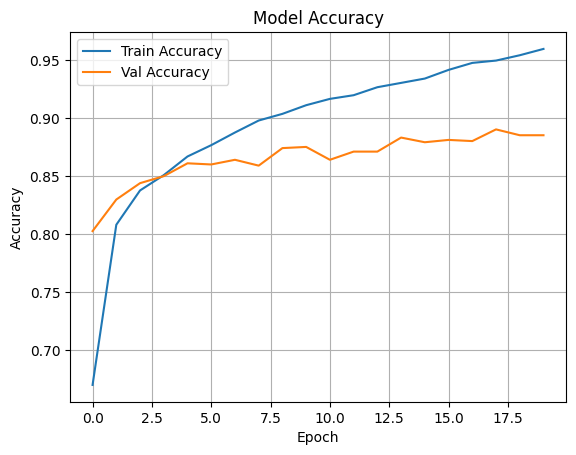

In [19]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['classification_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [20]:
model.save("ssd_mobilenet_model.h5")


In [27]:
import numpy as np

y_true = []
y_pred = []

for batch_images, batch_labels in val_gen:
    if batch_images.shape[0] == 0:
        break  # Skip empty batch if any

    # Extract true labels safely
    true_batch = batch_labels['classification_output']
    if true_batch.ndim == 1:
        true_classes = true_batch
    else:
        true_classes = np.argmax(true_batch, axis=1)

    # Predict using model
    preds = model.predict(batch_images, verbose=0)
    predicted_classes = np.argmax(preds[0], axis=1)

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

    if len(y_true) >= len(val_gen) * val_gen.batch_size:
        break


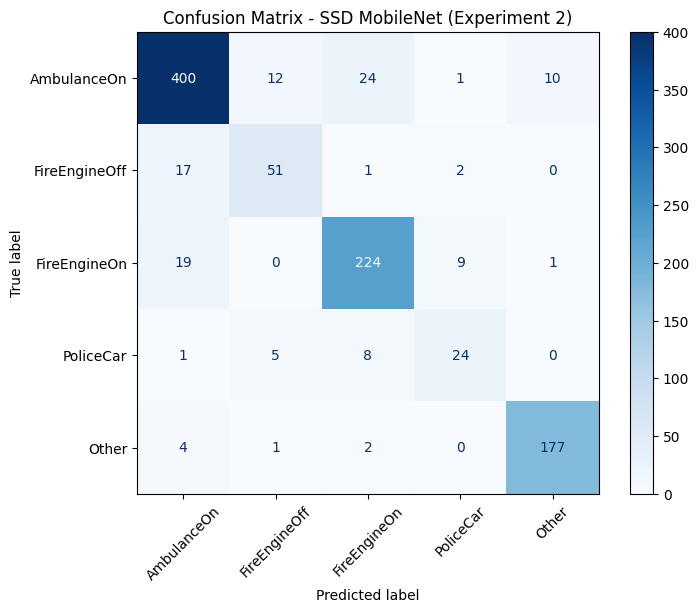


Classification Report:

               precision    recall  f1-score   support

  AmbulanceOn       0.91      0.89      0.90       447
FireEngineOff       0.74      0.72      0.73        71
 FireEngineOn       0.86      0.89      0.88       253
    PoliceCar       0.67      0.63      0.65        38
        Other       0.94      0.96      0.95       184

     accuracy                           0.88       993
    macro avg       0.82      0.82      0.82       993
 weighted avg       0.88      0.88      0.88       993



In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Automatically detect unique labels
unique_labels = np.unique(y_true + y_pred)

# Optional: manually map label indices to names if needed
class_names = ['AmbulanceOff', 'AmbulanceOn', 'FireEngineOff', 'FireEngineOn', 'PoliceCar', 'Other']

# Filter class_names to match what was actually used
filtered_class_names = [class_names[i] for i in unique_labels]

# Confusion matrix and display
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=filtered_class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix - SSD MobileNet (Experiment 2)")
plt.show()

# Print metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))


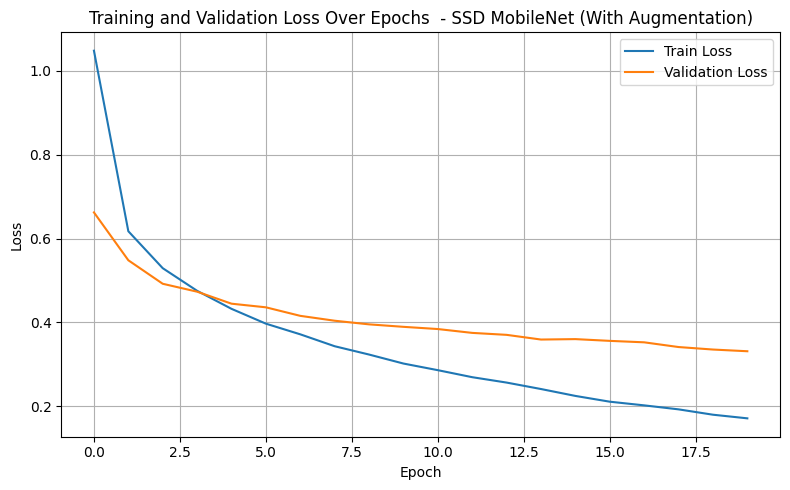

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation loss for Experiment 2
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs  - SSD MobileNet (With Augmentation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
